# Algorithms in Bioinformatics project, Supplementary Notebook
## Testing the Aligner

The below cell loads the code of the aligner into the notebook, allowing more direct testing. Since the text of the code is loaded into the notebook, \_\_name\_\_ == "\_\_main\_\_" evaluates to true, which means this snippet will crash upon running since it's not passed any arguments. However, all the functions will be loaded, which is what we're actually after, so no harm done.

In [ ]:
%load aligner.py

Some simple test-cases:

In [ ]:
print(needle_affine('AAT', 'ACACT', gap = -1, opengap = -3, local_align = True))
print(needle_affine('ARACCCWC', 'ARQAAWC', EMBOSS = True))
print(needle_affine('AAAGAATTCA', 'AAATCA', EMBOSS = True))
print(needle_affine('MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR', 'MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR'))

### Testing of Algorithm Optimization

The line_profiler shows (in a popup) how much time is spent at each line of the function. For ease of reading, the test case is displayed in the cell below.

In [ ]:
%load_ext line_profiler
%lprun -f needle_affine needle_affine('MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR', 'MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR')

As can be seen above, the backtracking takes barely any time at all compared to the filling in of the matrix, so working on it would produce negliable differences in performance. The most time-consuming step of the calculations seem to be using numpy's argmax function. Of course, the way its done here, taking max() and the np.argmax() on the same statement, is inefficient, making the approximately same calculation multiple times. Since the in-built max() function works on the first element of each sub-list if there are sub-lists, an implementation using it instead might be faster:

In [ ]:
%load aligner_optimized.py

In [ ]:
%load_ext line_profiler
%lprun -f needle_affine needle_affine('MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR', 'MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR')

As we can see, this sped up the algorithm considerably. Revisiting the test cases above confirms that the alignments produced are just as good as before, although the new version tends to choose different routes.

### Complexity Estimation (big Oh)
The line_profiler helpfully includes the number of times any individual line was hit, making Ordo calculations simple.

As can be seen from the line_profiler result, the lines are either hit $1$, $n$, $n+1$, $n^{2}$, or $n^{2}+1$ times each ($n=m=142$ in the example run), meaning the complexity is implied to be $O(nm)$, $O(n^{2})$, or $O(m^{2})$. In this case, it would be $O(nm)$, considering the complexity depends on the two for-loops with length $n$ and $m$ respectively.

Of course, it is the worst case scenario that should set the complexity, and in this case the worst case scenario would be that nothing aligns, and just having series of gaps aligned to each other. This however would just affect the traceback step (as the full matrices still need to be calculated), and the complexity of the traceback would become $n+m$ which does not affect the overall complexity.

## Runtime analysis
Random sequences of varying lengths are generated and the run-time of the aligner is analysed for each one

In [2]:
import random
import time
import numpy as np
residues = 'ACDEFGHIKLMNPQRSTVWY'
times = []
length_range = range(5, 300, 20)
for l in length_range:
    timelist = []
    for i in range(100):
        sequences = (''.join([random.choice(residues) for i in range(l)]), ''.join([random.choice(residues) for i in range(l)]))
        start = time.time()
        alignment = needle_affine(sequences[0], sequences[1])
        timelist.append(time.time() - start)
    times.append([np.mean(timelist), np.std(timelist)])
times_mean, times_std = zip(*times)

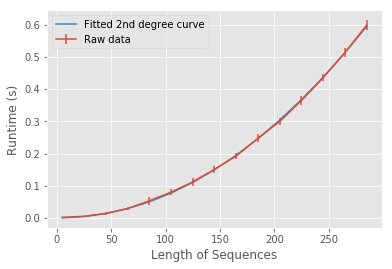

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import scipy.optimize as opt

plt.errorbar(length_range, times_mean, yerr = times_std, label = 'Raw data')
z = np.polyfit(length_range, times_mean, 2)
f = np.poly1d(z)
plt.plot(length_range, f(length_range), label="Fitted 2nd degree curve")
plt.legend()
plt.xlabel('Length of Sequences')
plt.ylabel('Runtime (s)')
plt.savefig('timefig.pdf')
plt.show()